In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from dataset import prepare_dataset

In [2]:
def train_model(
    train_loader,
    test_loader,
    num_epochs=25,
    learning_rate=0.001,
    model_type="resnet18",
    device="cuda",
):
    if isinstance(model_type, str):
        if model_type == "resnet18":
            model = models.resnet18(pretrained=True)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, len(set(train_loader.dataset.image_paths)))
        elif model_type == "resnet50":
            model = models.resnet50(pretrained=True)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, len(set(train_loader.dataset.image_paths)))
        elif model_type == "densenet121":
            model = models.densenet121(pretrained=True)
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(
                num_ftrs, len(set(train_loader.dataset.image_paths))
            )
        elif model_type == "efficientnet_b0":
            model = models.efficientnet_b0(pretrained=True)
            num_ftrs = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(
                num_ftrs, len(set(train_loader.dataset.image_paths))
            )
        else:
            raise ValueError(f"Unsupported model type: {model_type}")
    else:
        model = model_type

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]"):
            inputs = batch["image"].to(device)
            class_names = batch["class_name"]
            class_to_idx = {name: i for i, name in enumerate(sorted(set(class_names)))}
            labels = torch.tensor(
                [class_to_idx[name] for name in class_names], device=device
            )

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in tqdm(
                test_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]"
            ):
                inputs = batch["image"].to(device)
                class_names = batch["class_name"]
                labels = torch.tensor(
                    [class_to_idx[name] for name in class_names], device=device
                )
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(test_loader.dataset)
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}"
        )
        scheduler.step()

    print("Finished Training")
    return (
        model,
        train_loss_history,
        train_acc_history,
        val_loss_history,
        val_acc_history,
    )

In [3]:
def run_training(
    root_directory,
    model_save_path="trained_nail_model.pth",
    num_epochs=10,
    learning_rate=0.001,
    model_type="resnet18",
    batch_size=32,
):
    train_loader, test_loader = prepare_dataset(root_directory, batch_size=batch_size)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    trained_model, train_loss, train_acc, val_loss, val_acc = train_model(
        train_loader,
        test_loader,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        model_type=model_type,
        device=device,
    )

    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Trained model saved to '{model_save_path}'")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.tight_layout()
    plt.show()

    return trained_model

Using device: cuda


/home/akar/repo/thesis/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/akar/repo/thesis/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 1.7079, Train Acc: 0.4562, Val Loss: 10.3645, Val Acc: 0.5188


Epoch 2/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 0.9340, Train Acc: 0.5544, Val Loss: 1.8152, Val Acc: 0.4813


Epoch 3/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 0.8837, Train Acc: 0.5906, Val Loss: 5.0935, Val Acc: 0.4313


Epoch 4/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.7910, Train Acc: 0.6239, Val Loss: 2.2836, Val Acc: 0.4813


Epoch 5/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.7032, Train Acc: 0.6873, Val Loss: 3.2279, Val Acc: 0.3937


Epoch 6/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.6540, Train Acc: 0.7175, Val Loss: 3.9911, Val Acc: 0.4562


Epoch 7/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 0.5711, Train Acc: 0.7644, Val Loss: 1.6863, Val Acc: 0.4562


Epoch 8/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.3791, Train Acc: 0.8565, Val Loss: 1.4541, Val Acc: 0.4938


Epoch 9/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.2269, Train Acc: 0.9456, Val Loss: 1.7157, Val Acc: 0.5062


Epoch 10/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.1637, Train Acc: 0.9471, Val Loss: 2.0862, Val Acc: 0.4938
Finished Training
Trained model saved to 'trained_nail_model.pth'


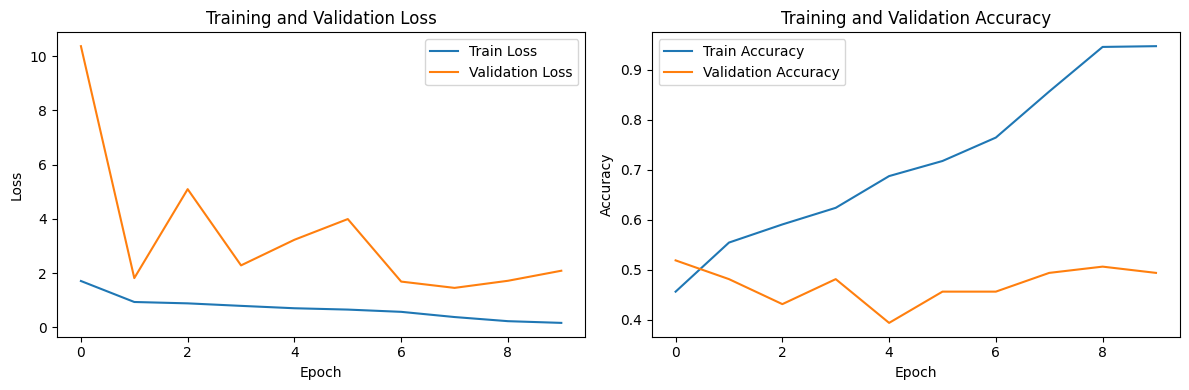

In [4]:
dataset_dir = "./datasets/dataset"
trained_model = run_training(dataset_dir, num_epochs=10, model_type="resnet50")

Using device: cuda


/home/akar/repo/thesis/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/akar/repo/thesis/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 2.0388, Train Acc: 0.4743, Val Loss: 2.2596, Val Acc: 0.4500


Epoch 2/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 0.7738, Train Acc: 0.6692, Val Loss: 1.9131, Val Acc: 0.4562


Epoch 3/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 0.5353, Train Acc: 0.7749, Val Loss: 1.8502, Val Acc: 0.4562


Epoch 4/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.3821, Train Acc: 0.8701, Val Loss: 2.2276, Val Acc: 0.4875


Epoch 5/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.4372, Train Acc: 0.8233, Val Loss: 1.5387, Val Acc: 0.4938


Epoch 6/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.2602, Train Acc: 0.9124, Val Loss: 7.6890, Val Acc: 0.4375


Epoch 7/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 0.1782, Train Acc: 0.9411, Val Loss: 2.0421, Val Acc: 0.5125


Epoch 8/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.0809, Train Acc: 0.9819, Val Loss: 1.6863, Val Acc: 0.5750


Epoch 9/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.0300, Train Acc: 0.9985, Val Loss: 1.6388, Val Acc: 0.5687


Epoch 10/10 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.0232, Train Acc: 1.0000, Val Loss: 1.6452, Val Acc: 0.5813
Finished Training
Trained model saved to 'trained_nail_model.pth'


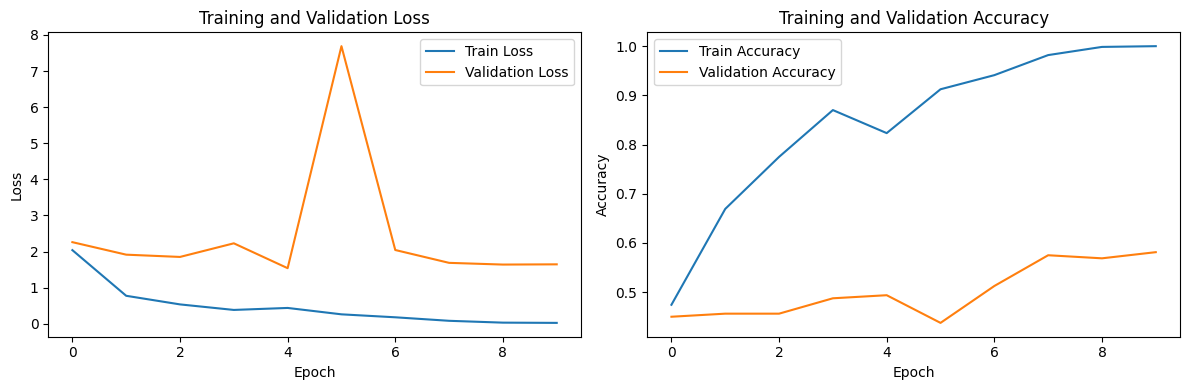

In [6]:
trained_model_densenet = run_training(
    dataset_dir, num_epochs=10, model_type="densenet121"
)